# Object Detection using the YOLO V4 custom-trained model

In this exercise we will experiment with object detection in still images using the YOLO V4 custom trained model for detecting face masks. Note  that  this is not a face detector. 

## Setup

In [1]:
# import the relevant libraries
import numpy as np
import cv2 # openCV

In [2]:
# check the opencv version
print(cv2.__version__)

4.5.2


In [3]:
# if the openCV version is < 4.4.0 update to the latest otherwise skip this step
!pip install opencv-python==4.5.2.52

## Get the model

mount your Google Drive!

In [3]:
# first create a directory to store the model
%mkdir model

mkdir: cannot create directory ‘model’: File exists


In [5]:
# enter the directory and download the necessary files 
%cd model
%cp /content/drive/MyDrive/my_model/backup/yolov4_best.weights .
%cp /content/drive/MyDrive/my_model/yolov4.cfg .
%cp /content/drive/MyDrive/my_model/face_mask_classes.names .
%cd ..

/content/model
/content


##  Get the test data

In [6]:
# create a directory for test data
%mkdir test_data

mkdir: cannot create directory ‘test_data’: File exists


In [18]:
# copy a test file locally or use it directly from the mounted drive 
# customize this example for your drive structure
%cp /content/drive/MyDrive/data/object_detection/test_gko_rs.jpg test_data/
%cp /content/drive/MyDrive/data/object_detection/test_gko_rs_ground_truth.txt test_data/

## Read test image

In [3]:
# read file
test_img = cv2.imread('test_data/test_gko_rs.jpg')

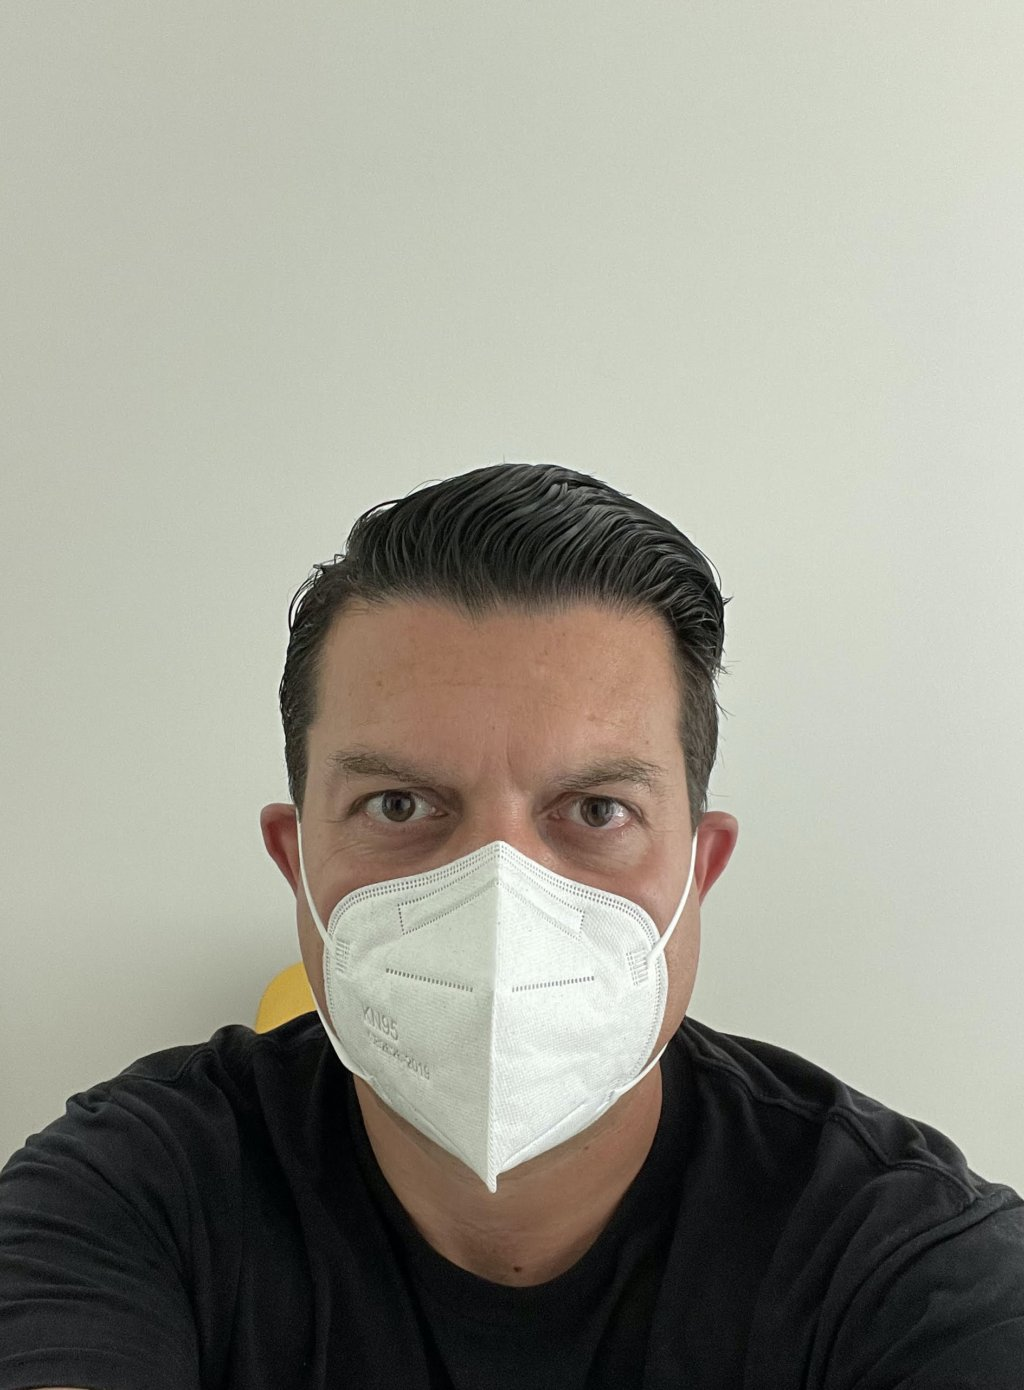

In [4]:
# display test image
# import the cv2_imshow as a replacement of cv2.imshow to prevent errors
from google.colab.patches import cv2_imshow
cv2_imshow(test_img)

## Image2Blob

convert the image to blob for model compatibility using the opencv builtin  dnn.blobFromImage() method

Argument explanations:
- scalefactor: multiplication factor for each pixel to rescale its intensity in  the range of [0,1]. No contrast stretching is performed. It is set to 1/255.0 = 0.003922.
- new_size: rescaling size for network compatibility. We use (416, 416). Other supported sizes are (320, 320) and (609, 609). The greater the size is the better the prediction accuracy will be but at the cost of higher computational load.
- swapRB: binary flag that if set instructs opencv to swap the red and blue channels. That is because opencv stores images in a BGR order but YOLO requires them in RGB.
- crop: binary flag that if set instructs opencv to crop the image after resizing.


In [5]:
scalefactor = 1.0/255.0
new_size = (416, 416)
blob = cv2.dnn.blobFromImage(test_img, scalefactor, new_size, swapRB=True, crop=False)

## Customize the YOLO detector

class labels:

In [6]:
class_labels_path = "/content/model/face_mask_classes.names"
class_labels = open(class_labels_path).read().strip().split("\n")
class_labels

['no face mask', 'face mask']

bounding box color definitions: two options

In [7]:
# declare repeating bounding box colors for each class 
# 1st: create a list colors as an RGB string array
# Example: Red, Green,
class_colors = ["255,0,0","0,255,0"]

#2nd: split the array on comma-seperated strings and for change each string type to integer
class_colors = [np.array(every_color.split(",")).astype("int") for every_color in class_colors]

#3d: convert the array or arrays to a numpy array
class_colors = np.array(class_colors)

## Load and run the model

In [8]:
# Load the pre-trained model 
yolo_model = cv2.dnn.readNetFromDarknet('model/yolov4.cfg','model/yolov4_best.weights')

In [9]:
# Read the network layers/components. The YOLO V4 neural network has 379 components.
# They consist of convolutional layers (conv), rectifier linear units (relu) etc.:
model_layers = yolo_model.getLayerNames()
print("number of network components: " + str(len(model_layers))) 
print(model_layers)

number of network components: 379
['conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5', 'bn_5', 'mish_6', 'conv_6', 'bn_6', 'mish_7', 'shortcut_7', 'conv_8', 'bn_8', 'mish_9', 'concat_9', 'conv_10', 'bn_10', 'mish_11', 'conv_11', 'bn_11', 'mish_12', 'conv_12', 'bn_12', 'mish_13', 'identity_13', 'conv_14', 'bn_14', 'mish_15', 'conv_15', 'bn_15', 'mish_16', 'conv_16', 'bn_16', 'mish_17', 'shortcut_17', 'conv_18', 'bn_18', 'mish_19', 'conv_19', 'bn_19', 'mish_20', 'shortcut_20', 'conv_21', 'bn_21', 'mish_22', 'concat_22', 'conv_23', 'bn_23', 'mish_24', 'conv_24', 'bn_24', 'mish_25', 'conv_25', 'bn_25', 'mish_26', 'identity_26', 'conv_27', 'bn_27', 'mish_28', 'conv_28', 'bn_28', 'mish_29', 'conv_29', 'bn_29', 'mish_30', 'shortcut_30', 'conv_31', 'bn_31', 'mish_32', 'conv_32', 'bn_32', 'mish_33', 'shortcut_33', 'conv_34', 'bn_34', 'mish_35', 'conv_35', 'bn_35', 'mish_36', 'shortcut_36', 'conv_37', 'bn_37', 'm

In [10]:
# Loop through all network layers to find the output layers
output_layers = [model_layers[model_layer[0] - 1] for model_layer in yolo_model.getUnconnectedOutLayers()]

# YOLOv4 deploys the same YOLO head as YOLOv3 for detection with   
# the anchor based detection steps, and three levels of detection granularity. 
print(output_layers)

['yolo_139', 'yolo_150', 'yolo_161']


In [11]:
# input pre-processed blob into the model
yolo_model.setInput(blob)

# compute the forward pass for the input, storing the results per output layer in a list
obj_detections_in_layers = yolo_model.forward(output_layers)

# verify the number of sets of detections
print("number of sets of detections: " + str(len(obj_detections_in_layers)))

number of sets of detections: 3


## Analyze the results

The objective now is to get each object detection from each output layer and evaluate  the algorithm's cofidence score against a threshold. For high confidence detections we extract the class ID and the bounding box info.

## Non Maxima Suppression (NMS)

supress fully or partially overlapping bounding boxes

In [12]:
%cp /content/drive/MyDrive/object_detection_functions.py .

In [13]:
from object_detection_functions import object_detection_analysis_with_nms

In [14]:
score_threshold = 0.5
nms_threshold = 0.4
result, winner_boxes = object_detection_analysis_with_nms(test_img, class_labels, class_colors, obj_detections_in_layers, score_threshold, nms_threshold)

predicted object face mask: 98.57%


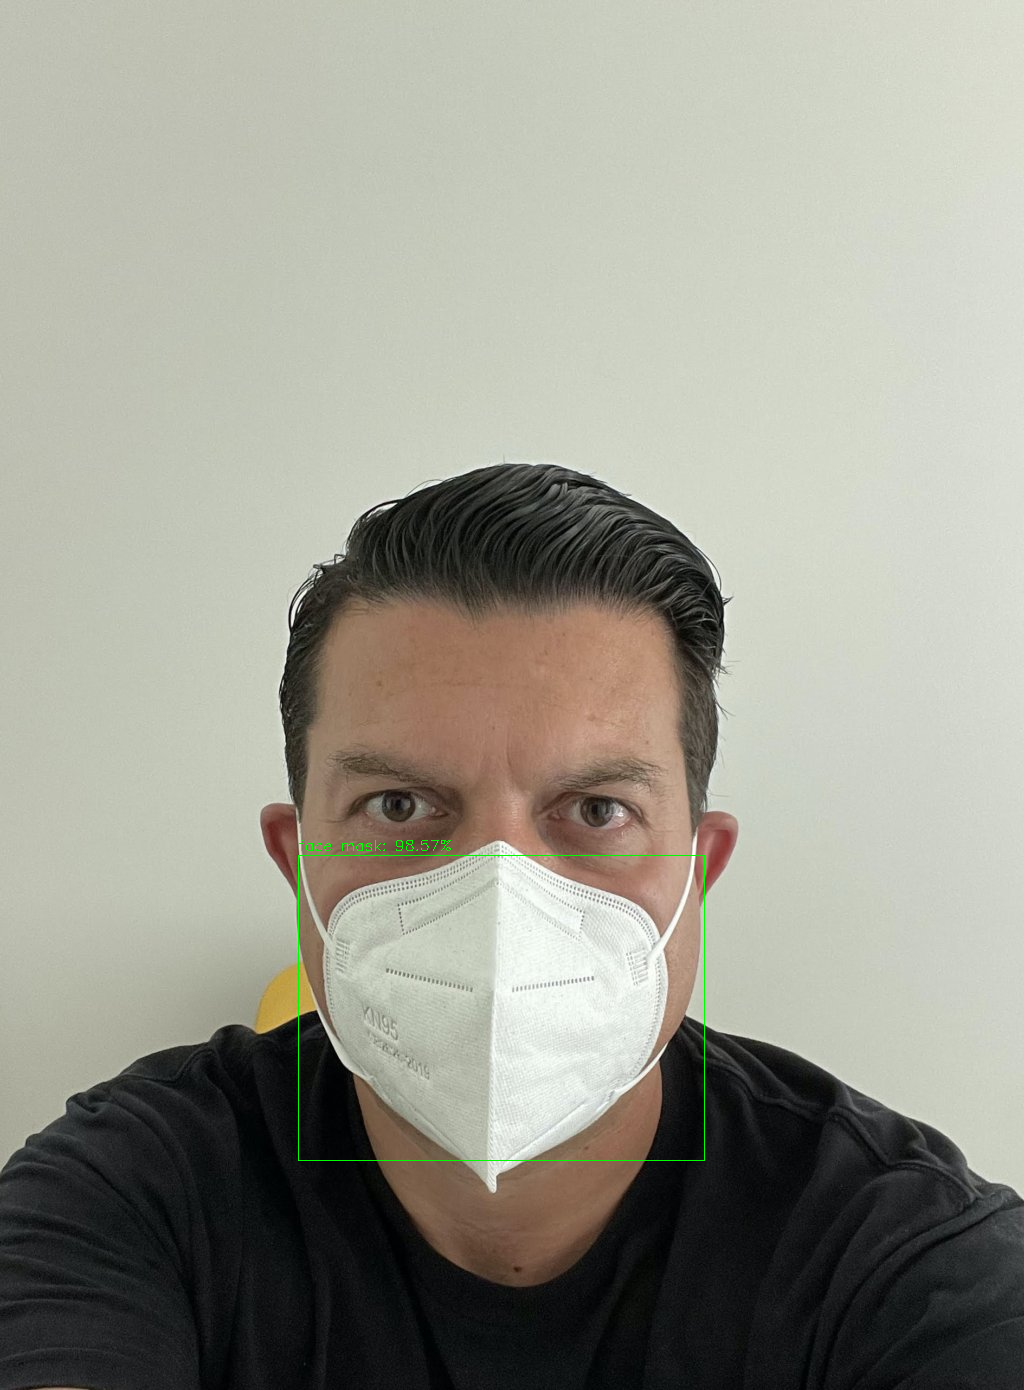

In [15]:
cv2_imshow(result)

create a 2D list containing the bounding box end points for each detection.

create a 2D list containing the ground truth box end points for each object.

both lists must be of the same dimensions

In [16]:
import io

ground_truth_boxes = []

with io.open("test_data/test_gko_rs_ground_truth.txt", mode="r", encoding="utf-8") as f:
  for line in f:
    ground_truth_boxes.append(line.split())

for i in range(0, len(ground_truth_boxes)):
  for j in range(0, len(ground_truth_boxes[i])):
    ground_truth_boxes[i][j] = int(ground_truth_boxes[i][j])

### Compute the IoU metric

The green bounding boxes depict the detected object while the red, the ground truth object

In [17]:
from object_detection_functions import object_detection_iou

In [18]:
# create a copy of the test image
iou_image = test_img.copy()

# print the ground truth and detection bounding boxes, and the IoU value
iou_image, iou_value = object_detection_iou(test_img, winner_boxes[0], ground_truth_boxes[0])

iou = 0.8510


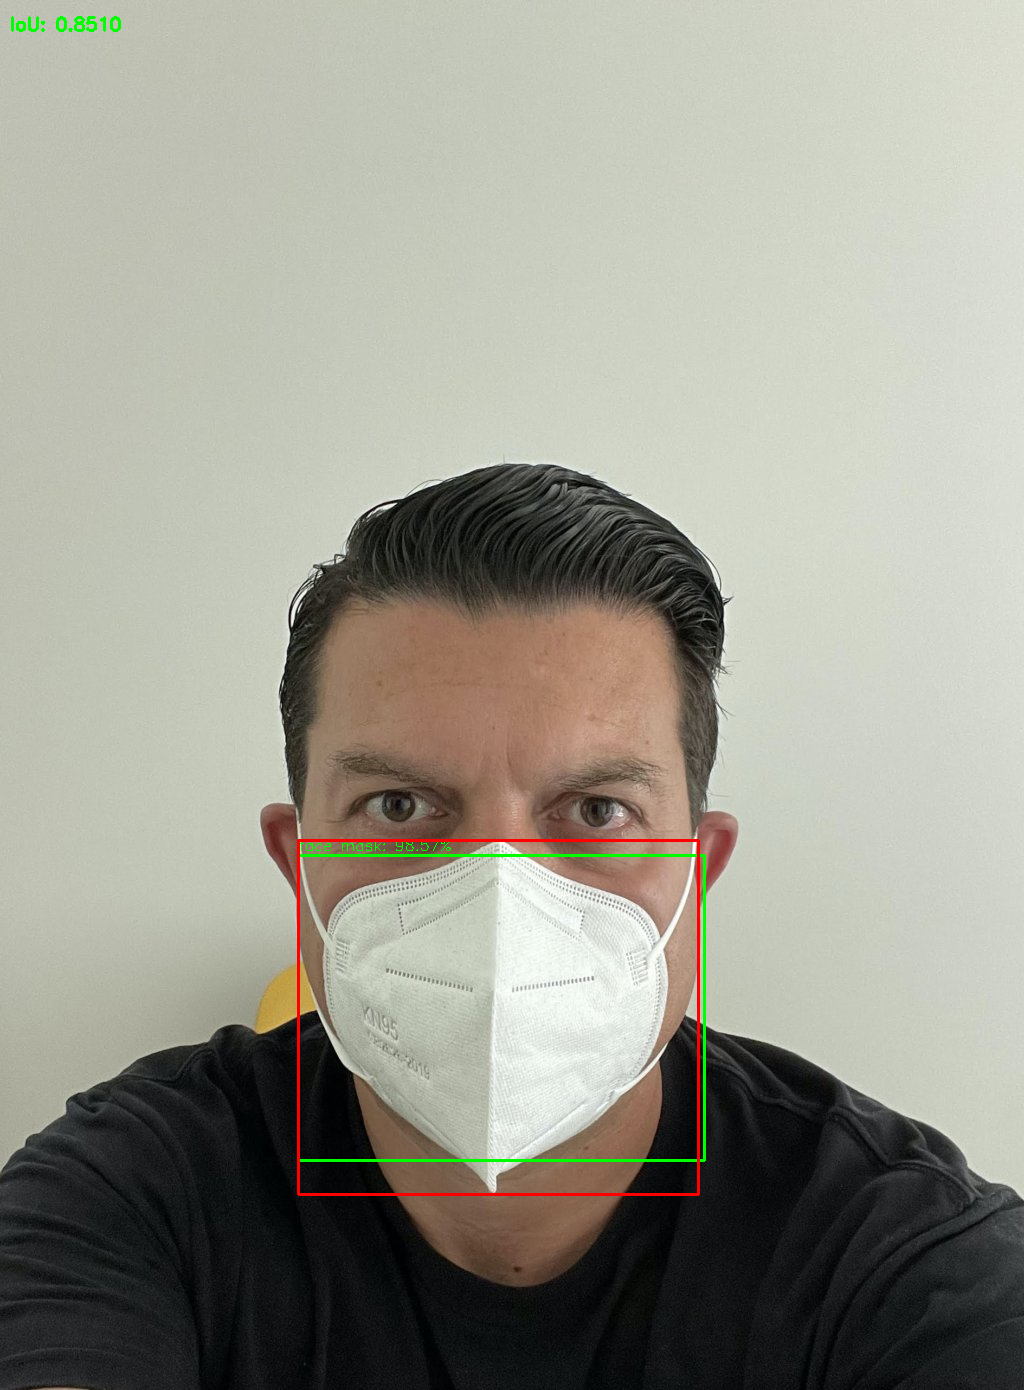

In [19]:
cv2_imshow(iou_image)